<a href="https://colab.research.google.com/github/mathieuroig9/Statapp/blob/main/LL_test_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt

In [37]:
!python -m examples.sde_gan

/usr/bin/python3: No module named examples.sde_gan


# 1 préparation des données

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/mathieuroig9/Statapp/refs/heads/main/EUR_4Q24_EUR_3000.csv", sep=";", decimal = ",", encoding="utf-8")
data.columns = data.columns.str.replace(' ', '_')
# Détection des colonnes de taux
rate_columns = [col for col in data.columns if 'EUR_Nom_Spot_' in col]
print(data.shape)
print(data.head())

(123000, 44)
   Scenario  Time_Step  EUR_Nom_Spot_1  EUR_Nom_Spot_2  EUR_Nom_Spot_3  \
0         1          0        0.023360        0.021924        0.021930   
1         1          1        0.004213        0.004661        0.005202   
2         1          2       -0.004657       -0.004205       -0.003783   
3         1          3       -0.010183       -0.009844       -0.009144   
4         1          4       -0.008092       -0.007204       -0.006397   

   EUR_Nom_Spot_4  EUR_Nom_Spot_5  EUR_Nom_Spot_6  EUR_Nom_Spot_7  \
0        0.022201        0.022420        0.022705        0.022980   
1        0.005659        0.006225        0.006802        0.007357   
2       -0.003147       -0.002466       -0.001797       -0.001175   
3       -0.008381       -0.007633       -0.006941       -0.006197   
4       -0.005682       -0.005078       -0.004439       -0.003969   

   EUR_Nom_Spot_8  ...  EUR_Nom_Spot_33  EUR_Nom_Spot_34  EUR_Nom_Spot_35  \
0        0.023225  ...         0.020410         0.

In [40]:
Xtrain = []

for i in range(1, 3001):
  scen_i = data.loc[data["Scenario"] == i].values
  Xtrain.append(scen_i[:,2:-2])


Xtrain = np.array(Xtrain)
Xtrain[0,:,:]
Xtrain.shape

(3000, 41, 40)

#2.1 - Keras tuner GAN


In [44]:
#Target chatGPT



class GANHyperModel(kt.HyperModel):

    def build_generator(self, hp):

      latent_dim = hp.Int("latent_dim", 32, 128, step=32)
      model = tf.keras.Sequential()
      model.add(layers.Input(shape=(latent_dim,)))
      model.add(layers.Dense(128 * 10 * 10))
      model.add(layers.Reshape((1, 10, 10, 128)))  # Pour ConvLSTM2D

      model.add(layers.ConvLSTM2D(64, (3,3), padding="same", return_sequences=True))
      model.add(layers.BatchNormalization())
      model.add(layers.ReLU())

      model.add(layers.ConvLSTM2D(32, (3,3), padding="same", return_sequences=True))
      model.add(layers.BatchNormalization())
      model.add(layers.ReLU())

      model.add(layers.Flatten())
      model.add(layers.Dense(41 * 40, activation='linear'))
      model.add(layers.Reshape((41, 40)))  # Output

      return model

    def build_discriminator(self, hp):

      model = tf.keras.Sequential()
      model.add(layers.Input(shape=(41, 40)))
      model.add(layers.Reshape((41, 40, 1)))
      model.add(layers.Conv2D(64, (3, 3), strides=2, padding="same"))
      model.add(layers.LeakyReLU(0.2))
      model.add(layers.Conv2D(128, (3, 3), strides=2, padding="same"))
      model.add(layers.LeakyReLU(0.2))
      model.add(layers.Flatten())
      model.add(layers.Dense(1, activation="sigmoid"))
      return model

    def build_gan(self, generator, discriminator):
      discriminator.trainable = False
      gan_input = tf.keras.Input(shape=(generator.input_shape[1],))
      generated_seq = generator(gan_input)
      validity = discriminator(generated_seq)
      gan = tf.keras.Model(gan_input, validity)
      gan.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="binary_crossentropy")
      return gan


    def build(self, hp):

        self.generator = self.build_generator(hp)
        self.discriminator = self.build_discriminator(hp)
        self.discriminator.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="binary_crossentropy")
        return self.build_gan(self.generator, self.discriminator)

    def fit(self, hp, model, x, y=None, **kwargs):

        real_data = x
        batch_size = 64
        epochs = 5
        latent_dim = model.input_shape[1]

        for epoch in range(epochs):
            for i in range(0, len(real_data), batch_size):

                real_batch = real_data[i:i + batch_size]
                noise = tf.random.normal((len(real_batch), latent_dim))
                fake_batch = self.generator.predict(noise, verbose=0)

                X_combined = tf.concat([real_batch, fake_batch], axis=0)
                y_combined = tf.concat([tf.ones((len(real_batch), 1)), tf.zeros((len(fake_batch), 1))], axis=0)

                self.discriminator.trainable = True
                self.discriminator.train_on_batch(X_combined, y_combined)

                noise = tf.random.normal((len(real_batch), latent_dim))
                y_misleading = tf.ones((len(real_batch), 1))

                self.discriminator.trainable = False
                model.train_on_batch(noise, y_misleading)

        return {"val_loss": 0.0}



tuner = kt.Hyperband(
    GANHyperModel(),
    objective="val_loss",
    max_epochs=20,
    directory="gan_tuning_dir",
    project_name="gan_generator_tuning"
)

tuner.search(Xtrain)


Trial 4 Complete [00h 04m 56s]
val_loss: 0.0

Best val_loss So Far: 0.0
Total elapsed time: 00h 12m 53s


In [52]:
best_trial = tuner.oracle.get_trial(tuner.oracle.get_best_trials(1)[0].trial_id)
print("ID du meilleur trial :", best_trial.trial_id)
print("Hyperparamètres du meilleur trial :")
for key, value in best_trial.hyperparameters.values.items():
    print(f"{key}: {value}")

best_hp = tuner.get_best_hyperparameters(int(best_trial.trial_id))[0]
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

ID du meilleur trial : 0002
Hyperparamètres du meilleur trial :
latent_dim: 128
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0


Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 41, 40)         │     7,454,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 1)              │        88,577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,543,145 (28.77 MB)

 Trainable params: 7,454,376 (28.44 MB)

 Non-trainable params: 88,769 (346.75 KB)

In [58]:
def retrain_best_model(tuner, Xtrain, epochs=5, batch_size=64):

    best_trial = tuner.oracle.get_trial(tuner.oracle.get_best_trials(1)[0].trial_id)
    best_hp = tuner.get_best_hyperparameters(int(best_trial.trial_id))[0]
    best_model = tuner.hypermodel.build(best_hp)
    hypermodel = GANHyperModel()

    # Reconstruire le modèle GAN (générateur + discriminateur)
    gan_model = hypermodel.build(best_hp)

    # Accéder au générateur et discriminateur pour l'entraînement
    generator = hypermodel.generator
    discriminator = hypermodel.discriminator

    latent_dim = gan_model.input_shape[1]

    for epoch in range(epochs):
        for i in range(0, len(Xtrain), batch_size):
            real_batch = Xtrain[i:i + batch_size]

            # Génération de faux exemples
            noise = tf.random.normal((len(real_batch), latent_dim))
            fake_batch = generator.predict(noise, verbose=0)

            # Discriminateur : entraîner sur vrais + faux
            X_combined = tf.concat([real_batch, fake_batch], axis=0)
            y_combined = tf.concat([
                tf.ones((len(real_batch), 1)),  # vrais = 1
                tf.zeros((len(fake_batch), 1))  # faux = 0
            ], axis=0)

            discriminator.trainable = True
            discriminator.train_on_batch(X_combined, y_combined)

            # Générateur via GAN : leurrer le discriminateur
            noise = tf.random.normal((len(real_batch), latent_dim))
            y_misleading = tf.ones((len(real_batch), 1))  # les faux devraient paraître vrais

            discriminator.trainable = False
            gan_model.train_on_batch(noise, y_misleading)

        print(f"Epoch {epoch + 1}/{epochs} terminé.")

    return generator, discriminator, gan_model



generator, discriminator, gan_model = retrain_best_model(tuner, Xtrain, epochs=5)


Epoch 1/5 terminé.
Epoch 2/5 terminé.
Epoch 3/5 terminé.
Epoch 4/5 terminé.
Epoch 5/5 terminé.


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step
Forme des scénarios générés : (3000, 41, 40)


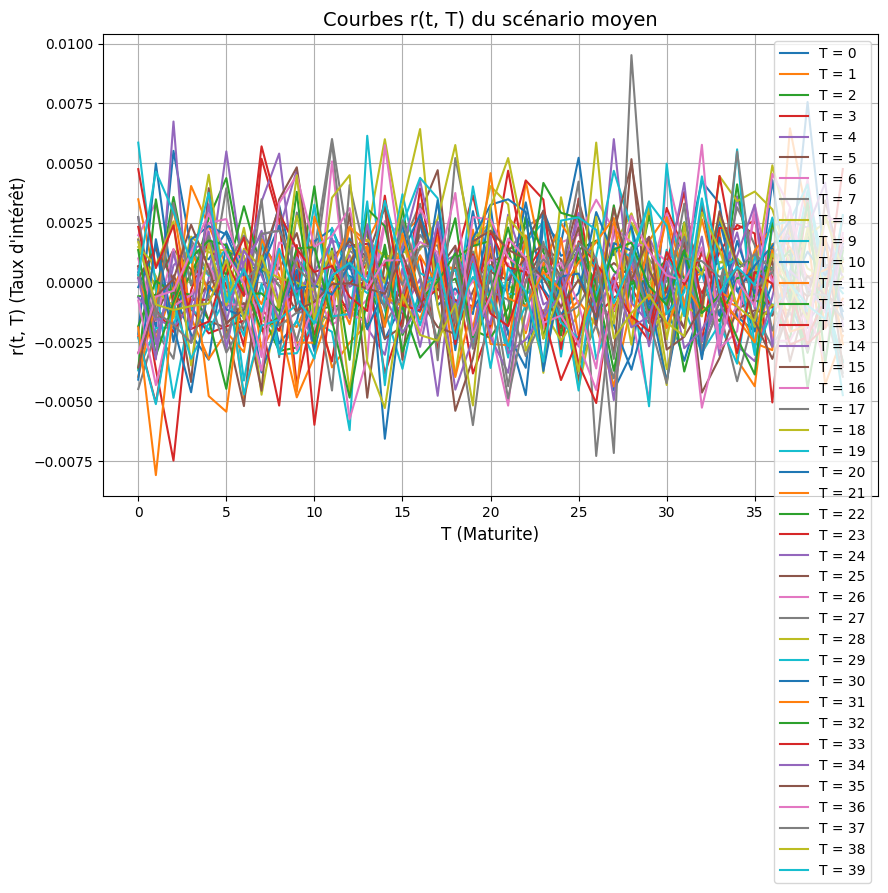

In [61]:
# Générer du bruit
latent_dim = generator.input_shape[1]
noise = np.random.normal(0, 1, size=(3000, latent_dim))

# Générer les scénarios
generated_scenarios = best_generator.predict(noise, verbose=1)

print("Forme des scénarios générés :", generated_scenarios.shape)



avg_scen = np.mean(generated_scenarios, axis = 0)


# Tracer les courbes r(t,T) pour t = 0, 1, ..., 40
plt.figure(figsize=(10, 6))
for T in range(avg_scen.shape[1]):
  plt.plot(np.arange(41), avg_scen[:, T], label='T = ' + str(T))
plt.xlabel('T (Maturite)', fontsize=12)
plt.ylabel('r(t, T) (Taux d\'intérêt)', fontsize=12)
plt.title('Courbes r(t, T) du scénario moyen', fontsize=14)
plt.grid(True)
plt.xticks(np.arange(0, 40, 5))  # Afficher les labels tous les 5 pas
plt.legend()
plt.show()

#2.2 PINN GAN

In [99]:
def lmm_drift(L, sigma, delta, rho):
    # L shape: (batch_size, time, tenor)
    batch_size, T, N = L.shape
    drift = tf.zeros_like(L)  # (batch_size, T, N)

    for i in range(N):
        sum_term = 0
        for j in range(i+1, N):
            denom = 1 + delta[j] * L[:, :, j]
            term = delta[j] * L[:, :, j] * sigma[i] * sigma[j] * rho[i, j] / denom
            sum_term += term

        # Créer les indices en 3D pour la mise à jour
        indices = tf.stack([
            tf.tile(tf.reshape(tf.range(batch_size), [-1, 1]), [1, T]),  # batch indices [batch_size, T]
            tf.tile(tf.reshape(tf.range(T), [1, -1]), [batch_size, 1]),  # time indices [batch_size, T]
            tf.fill([batch_size, T], i)  # tenor indices (constant 'i') [batch_size, T]
        ], axis=-1)  # (batch_size, T, 3)

        # S'assurer que sum_term est de la bonne forme (batch_size, T, N)
        sum_term_expanded = tf.expand_dims(sum_term, axis=-1)  # (batch_size, T, 1)
        sum_term_expanded = tf.tile(sum_term_expanded, [1, 1, N])  # (batch_size, T, N)

        # Mise à jour dans drift
        drift = tf.tensor_scatter_nd_add(drift, indices, sum_term_expanded)

    return drift


def retrain_best_model(tuner, Xtrain, epochs=5, batch_size=64, sigma=None, delta=None, rho=None, lambda_phys=1.0):
    import tensorflow as tf

    best_trial = tuner.oracle.get_trial(tuner.oracle.get_best_trials(1)[0].trial_id)
    best_hp = tuner.get_best_hyperparameters(int(best_trial.trial_id))[0]
    hypermodel = GANHyperModel()
    gan_model = hypermodel.build(best_hp)

    generator = hypermodel.generator
    discriminator = hypermodel.discriminator
    latent_dim = gan_model.input_shape[1]

    for epoch in range(epochs):
        for i in range(0, len(Xtrain), batch_size):
            real_batch = Xtrain[i:i + batch_size]

            # ==== Générer des données ====
            noise = tf.random.normal((len(real_batch), latent_dim))
            fake_batch = generator(noise, training=True)

            # ==== Approximation de dérivée temporelle ====
            dL_dt = (fake_batch[:, 1:, :] - fake_batch[:, :-1, :]) / 1.0  # delta_t = 1

            # ==== Drift LMM ====
            drift = lmm_drift(fake_batch[:, :-1, :], sigma, delta, rho)

            # ==== Perte physique ====
            loss_phys = tf.reduce_mean(tf.square(dL_dt - drift))

            # ==== Entraînement discriminateur ====
            X_combined = tf.concat([real_batch, fake_batch], axis=0)
            y_combined = tf.concat([
                tf.ones((len(real_batch), 1)),
                tf.zeros((len(fake_batch), 1))
            ], axis=0)

            discriminator.trainable = True
            discriminator.train_on_batch(X_combined, y_combined)

            # ==== Entraînement générateur ====
            noise = tf.random.normal((len(real_batch), latent_dim))
            with tf.GradientTape() as tape:
                fake_paths = generator(noise, training=True)
                validity = discriminator(fake_paths)
                gan_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(validity), validity)
                gan_loss = tf.reduce_mean(gan_loss)

                # Drift LMM pour nouvelles trajectoires
                dL_dt = (fake_paths[:, 1:, :] - fake_paths[:, :-1, :])
                drift = lmm_drift(fake_paths[:, :-1, :], sigma, delta, rho)
                loss_phys = tf.reduce_mean(tf.square(dL_dt - drift))

                total_loss = gan_loss + lambda_phys * loss_phys

            grads = tape.gradient(total_loss, generator.trainable_variables)
            optimizer = tf.keras.optimizers.Adam(1e-4)
            optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        print(f"Epoch {epoch + 1}/{epochs} terminé. Loss GAN: {gan_loss.numpy():.4f}, LMM: {loss_phys.numpy():.4f}")

    return generator, discriminator, gan_model



sigma = np.full(40, 0.2)          # Exemple
delta = np.full(40, 0.25)         # Tenors de 3 mois
rho = np.eye(40)                  # Corrélation diagonale pour commencer
lambda_phys = 1.0                 # Pondération de la perte physique

generator, discriminator, gan_model = retrain_best_model(
    tuner, Xtrain, epochs=5,
    sigma=sigma, delta=delta, rho=rho,
    lambda_phys=lambda_phys
)

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2] name: 